# MO命令
    和POT一起，放在tools里面使用

In [ ]:
mo-->main_onnx-->main-->driver-->prepair_ir (生成graph)-->emit_ir

update_registration函数向注册表中加入操作符
utils.layer_to_class文件中调用这个update_registration函数，

In [ ]:
#Graph
    继承了nx.MultiDiGraph，因为要添加的节点有其他的用途，所以要对继承的方法进行重写，并且进行安全检查
    g.graph就是图的本身一些属性
    g.node就是字典了{'节点名字1':{节点属性，节点属性}，'节点名字2':{}}，所以要想找到途中的某个节点，等同于字典查找。所有节点独一无二
    g.edges 是存储节点连接情况的列表字典[(1, 2, {'weight': 10}), ('z', 'h', {})]，字典里保存了边的属性
#Node 
    唯一标识是它的名字id，绑定到图上
    它的属性也是保存在字典中，g['node_id']['attr_1']来进行查找，修改
    {'_in_ports':{0：Port1，1：Port2},'_out_ports':{0：Port1，1：Port2}，'in_ports_count':int,'out_ports_count':int，'kind':'op'}
    ,每个字典中存储的是Node保存的Port,同时，也可以直接用Node来修改Port。
    kind表示类型['in','out']
#Port
    Port(node,idx,'in')
    {'node'= node,'idx' = idx,'type' = type,'data' = self.DataAccessor(),'control_flow' = False,}

# Model Representation in Memory

    model -- a directed graph 
    nodes -- operations
    edges -- data passing from a producer operation (node) to a consumer operation (node).

整体流程
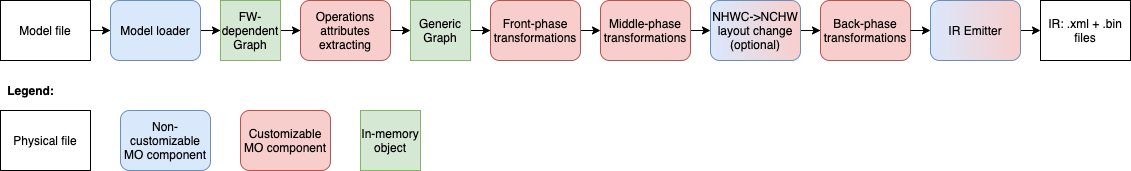

# Model Loading


    输入一个训练好的模型，根据其架构不同，要是使用不同的模型载入器
    extensions/load/<FRAMEWORK>/loader.py
    载入后就有了一个初步的图
 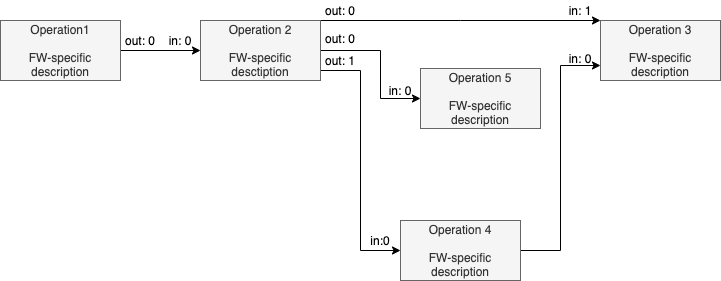
 
 其中的FW--specific是指，不同框架下的同一操作是不同的表示方法，所以要弄成一样的
 

# Operations Attributes Extracting

对FW-specific 操作进行表示解析，制作成一个Node，并且其中保存了attributes，用The extractor extension approach方法处理

处理完成后，整个图变成
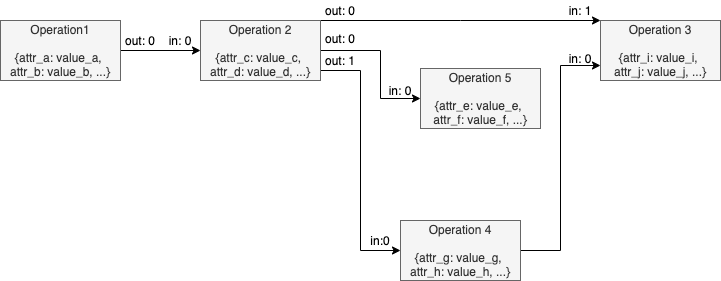
相当于把图的操作标准化成Node


# Front Phase

    因为 输入维度可能未知的情况，必须计算出所有数据的形状，满足某些需要形状的算子
    Using Shape Inference
    都在这个文件夹下面
    extensions/front/onnx/flattenONNX_to_reshape.py

# Partial Inference
    计算输出的形状，并且要写到IR中，对每一个OP都是用，就得到data节点
   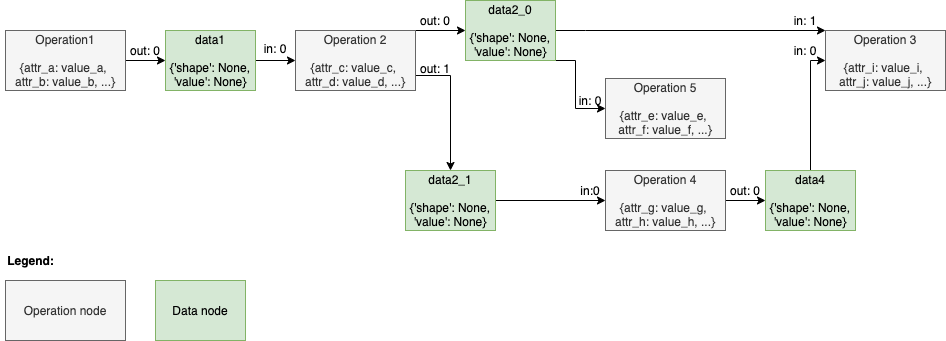
   
    这里就是强调，out只是OP的输出，而In是data的输出
    每个node都要有一个infer方法，来计算出输出结果的形状
 
    在mo/ops/reshape.py 文件加中
    @staticmethod
    def infer(node: Node):
        name = node.soft_get('name', node.id)

        input_shape = node.in_port(0).data.get_shape()  # get the input tensor shape
        new_shape = node.in_port(1).data.get_value()  # get the value defining the output tensor shape. This tensor may

        output_shape = ... # 计算输出的形状
        

        if node.in_port(0).data.get_value() is not None:  # if the input value is defined then calculate output value;

            node.out_port(0).data.set_value(node.in_port(0).data.get_value().reshape(output_shape))
        else:  # in the opposite case calculate the output shape only
            node.out_port(0).data.set_shape(output_shape)

# Middle Phase

 Middle Phase Transformations.

    NHWC to NCHW Layout Change
    还有其他类型的多个变换

# Back Phase

# Intermediate Representation Emitting
    Iterates over all operation nodes in the graph and checks that all nodes have the type attribute set. This attribute defines the operation type and is used in the Inference Engine to instantiate proper operation from the [opset](@ref openvino_docs_ops_opset) specified in the version attribute of the node. If some node does not have attribute type or its values is equal to None, the Model Optimizer exits with an error.
    Performs type inference of graph operations similar to the shape inference. Inferred data types are saved to a port attributes in the IR.
    Performs topological sort of the graph and changes id attribute of all operation nodes to be sequential integer values starting from 0.
    Saves all Constants values to the .bin file. Constants with the same value are shared among different operations.
    Generates an .xml file defining a graph structure. The information about operation inputs and outputs are prepared uniformly for all operations regardless of their type. A list of attributes to be saved to the .xml file is defined with the backend_attrs() or supported_attrs() of the Op class used for a graph node instantiation. For more information on how the operation attributes are saved to XML, refer to the function prepare_emit_ir() in the mo/pipeline/common.py file and Model Optimizer Operation.

# Ports

    
    node - 属于哪个节点
    idx - 编号，从0开始
    type - 是in 还是 out 就两个
    data - 存放的数据，要对其使用方法，设置shape,value,type
    
    get_shape()
    set_shape()
    get_value()  都是调用node.in_node(index)来实现修改
    set_value()
    get_attr()
    set_attr()
    
    disconnected

    ----outport会生成data类型的OP，data类型的Node包含shape,value,type属性，同时也可以infer来设置这些值--------------

    获得Port
    Node.in_port()
       .out_port()
       .add_input_port()加输入
       .add_output_port()加输出
       .delete_input_port()删除输入
       .delete_output_port() 删除输出
    
   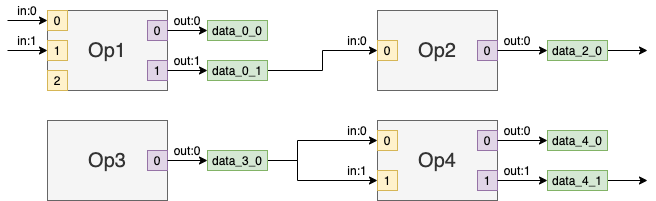
修改图的方法

     op4.in_port(1).disconnect()
     op3.out_port(0).connect(op4.in_port(1))
 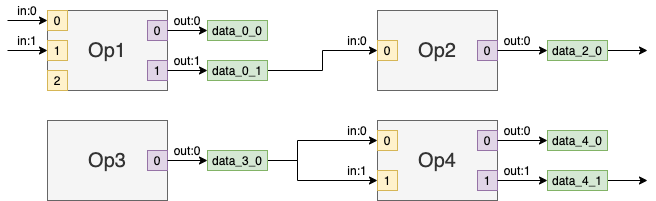

# NODE 类
  * 一个node是graph.node中的一个字典，用id来标识，属性
   
     type = 'in' or 'out'
     kind='op' or 'data'
     
    _in_ports={0:{},1:{},2:{}}  
    in_ports_count = 3
    
    _out_ports={0:{},1:{},2:{}}
    out_ports_count=3
    
    
   * add_input_port：添加一个输入Port
   * add_output_port：添加一个输出Port
   * delete_input_ports :删除输入Port
   * delete_input_port ：删除一个输入Port
   * delete_output_port:删除一个输出Port
   * delete_output_ports:删除输出Port
   * add_sequence_of_ports：添加一些Port
   * in_port：取出Port属性后，选中Port()
   * out_port:取出Port属性后，选中Port()
   * in_ports:返回所有的输入Port
   * out_ports:返回所有的输出Port
   * get_inputs：返回所有的前级输入节点
   * get_sorted_inputs：返回所有的前级输入节点的排序
   * get_outputs：返回所有的后级输出节点
   * get_sorted_outputs：返回所有的后级输出节点的排序
   * in_nodes：分data和op进行排序，返回所有的输入节点
   * out_nodes：分data和op进行排序，返回所有的输出节点
   * in_node：返回指定的输入节点
   * out_node: 返回指定的输出节点
   * in_edges：分data和op进行排序，返回所有的输入边
   * in_edge：指定输入边
   * out_edges：分data和op进行排序，返回所有的输出边
   * out_edge：指定输出边
   * edges：图中的所有有给定属性的边
   * edge：返回指定边
   * soft_get：返回属性，必有的属性（安全）

# Graph    
   * openvino通过将Graph类进行重写，增加了方法的安全性
   * 用node来替换Graph的nodes
   * 增加stage和strict_mode区分图的不同处理阶段
   * add_node：添加节点，增加安全性，返回新增的节点
   * add_edge：添加边，增加安全性，
   * add_edges_from：添加许多边
   * remove_edge：删除边
   * erase_node：删除节点
   * create_edge：创建并且添加一条边
   * unique_id：创建一个唯一的名字
   * get_nodes_with_attributes：返回有给定属性的节点
   * get_data_nodes：返回数据节点
   * get_op_nodes：返回OP节点

# Connections 类

    

Port.get_connection()获得一个Port的链接类
 
    op3.out_port(0).get_connection() 返回out0到data3_0的链接和两个从data3_0到后面的 两个链接

Connection:(self, graph, source, destinations: list,control_flow=False)

    get_source() - 返回输出port 注意，是输出，只有一个

    get_destinations() - 返回目标输入port 注意，是输入  是个列表
    get_destination() - 只返回一个输入port 修改图就是用这个修改的

    set_destination(dest_port) - 更改目标
    set_source(port) - 更改输入
    
    add_destination(port) - 增加目标
    
    remove(self) - 删除链接
    
i.e.
op3.out_port(0).get_connection().set_source(op1.out_port(0)) 

    



# 延伸的三个部分
    RUNTIME的C++实现
    MAP到IR的实现
    注册到Core中

# 使用OPENVINO自己的算子实现自定义的组合

In [ ]:
#将自定义算子MyRelu ，使用OPENVINO自带的RELU进行替换表示  1 VS 1
core.add_extension(ov::frontend::OpExtension<>("Relu", "MyRelu"));
#或者
core.add_extension(ov::frontend::OpExtension<>(ov::opset8::Relu , "MyRelu"));

#                                          
core.add_extension(ov::frontend::OpExtension<CustomOperation>(
    { 
        #实现属性的复制使得两个属性数据一样a==b，{“a”,“b”}
    {"attr1", "fw_attr1"}, 
     {"attr2", "fw_attr2"} },
    {}
));

In [1]:
#1 -to- M，将算子进行组合表示


#include <openvino/opsets/opset8.hpp>
core.add_extension(ov::frontend::ConversionExtension(
    "ThresholdedReLU",#ONNX中的算子名称
    [](const ov::frontend::NodeContext& node) {
        auto greater = std::make_shared<ov::opset8::Greater>(
            node.get_input(0),
            ov::opset8::Constant::create(ov::element::f32, {}, {node.get_attribute<float>("alpha")}));
        auto casted = std::make_shared<ov::opset8::Convert>(greater, ov::element::f32);
        return ov::OutputVector{ std::make_shared<ov::opset8::Multiply>(node.get_input(0), casted) };
    }));



SyntaxError: invalid syntax (Temp/ipykernel_1488/2756683634.py, line 5)